In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


In [4]:
df1 = pd.read_csv("Solar_flare_2002.csv")
df2 = pd.read_csv("Solar_flare_2004_05.csv")
df3 = pd.read_csv("Solar_flare_2015_16.csv")

df = pd.concat([df1, df2, df3], ignore_index=True)

In [5]:
df.head()

,duration.s,peak.c/s,total.counts,energy.kev,x.pos.asec,y.pos.asec,radial,active.region.ar,flag.1,flag.2,...,flag.4,flag.5,dt.start,dt.peak,dt.end,year,month,day,energy.kev.i,energy.kev.f
0,712,136,167304.0,12-25,592,-358,692,0,A1,P1,...,NaN,NaN,2002-02-12 21:29:56,2002-02-12 21:33:38,2002-02-12 21:41:48,2002,2,12,12,25
1,288,7,9504.0,6-12,604,-341,694,9811,A1,P1,...,Q1,NaN,2002-02-12 21:44:08,2002-02-12 21:45:06,2002-02-12 21:48:56,2002,2,12,6,12
2,216,15,11448.0,6-12,-310,375,487,9825,A1,P1,...,NaN,NaN,2002-02-13 00:53:24,2002-02-13 00:54:54,2002-02-13 00:57:00,2002,2,13,6,12
3,244,20,17400.0,12-25,-277,378,469,9822,A1,P1,...,NaN,NaN,2002-02-13 04:22:52,2002-02-13 04:23:50,2002-02-13 04:26:56,2002,2,13,12,25
4,236,336,313392.0,25-50,-272,390,476,9825,A1,GS,...,PE,Q2,2002-02-13 07:03:52,2002-02-13 07:05:14,2002-02-13 07:07:48,2002,2,13,25,50


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136467 entries, 0 to 136466
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   duration.s        136467 non-null  int64  
 1   peak.c/s          136467 non-null  int64  
 2   total.counts      136467 non-null  float64
 3   energy.kev        136467 non-null  object 
 4   x.pos.asec        136467 non-null  int64  
 5   y.pos.asec        136467 non-null  int64  
 6   radial            136467 non-null  int64  
 7   active.region.ar  136467 non-null  int64  
 8   flag.1            136467 non-null  object 
 9   flag.2            136467 non-null  object 
 10  flag.3            113164 non-null  object 
 11  flag.4            112879 non-null  object 
 12  flag.5            63588 non-null   object 
 13  dt.start          136467 non-null  object 
 14  dt.peak           136467 non-null  object 
 15  dt.end            136467 non-null  object 
 16  year              13

In [64]:
goes = pd.read_csv("goes_xrs.csv")

goes.head()

/tmp/ipython-input-2617209360.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  goes = pd.read_csv("goes_xrs.csv")


,time,xray_flux,flare_status
0,2001-03-01 00:00:00,3.478442e-07,NaN
1,2001-03-01 00:01:00,3.506659e-07,NaN
2,2001-03-01 00:02:00,3.533112e-07,NaN
3,2001-03-01 00:03:00,3.539179e-07,NaN
4,2001-03-01 00:04:00,3.518512e-07,NaN


In [65]:
goes = goes[['time','xray_flux']]
goes = goes.rename(columns={'xray_flux':'xrsb'})

goes['time'] = pd.to_datetime(goes['time'])
goes = goes.sort_values('time')

In [7]:
df['time'] = pd.to_datetime(df['dt.start'])
df = df.sort_values('time')

In [66]:
df = df.sort_values('time')
goes = goes.sort_values('time')

df = pd.merge_asof(
    df,
    goes[['time','xrsb']],
    on='time',
    direction='nearest'
)

In [67]:
df[['time','xrsb']].head()

,time,xrsb
0,2002-02-12 21:29:56,0.000002
1,2002-02-12 21:44:08,0.000003
2,2002-02-13 00:53:24,0.000002
3,2002-02-13 04:22:52,0.000003
4,2002-02-13 07:03:52,0.000007


In [69]:
df['xrsb'] = df['xrsb'].fillna(method='ffill').fillna(0)

/tmp/ipython-input-2596263912.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['xrsb'] = df['xrsb'].fillna(method='ffill').fillna(0)


In [70]:
df['goes_mean_30'] = df['xrsb'].rolling(30).mean().fillna(0)
df['goes_max_30']  = df['xrsb'].rolling(30).max().fillna(0)
df['goes_std_30']  = df['xrsb'].rolling(30).std().fillna(0)

In [8]:
df['flare_class'] = (df['energy.kev.f'] >= 50).astype(int)

df['time_gap'] = df['time'].diff().dt.total_seconds().fillna(0)


In [40]:
df['rolling_freq_50'] = df['flare_class'].rolling(50).mean().fillna(0)
df['rolling_peak_mean'] = df['peak.c/s'].rolling(50).mean().fillna(0)
df['rolling_energy_max'] = df['energy.kev.f'].rolling(50).max().fillna(0)


In [96]:
df['goes_lag_5'] = df['xrsb'].shift(5)
df['goes_lag_10'] = df['xrsb'].shift(10)
df['goes_lag_20'] = df['xrsb'].shift(20)

df[['goes_lag_5','goes_lag_10','goes_lag_20']] = \
df[['goes_lag_5','goes_lag_10','goes_lag_20']].fillna(method='ffill').fillna(0)

/tmp/ipython-input-3242559947.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[['goes_lag_5','goes_lag_10','goes_lag_20']].fillna(method='ffill').fillna(0)


In [10]:
horizon = 5

early_label = []

fc = df['flare_class'].values

for i in range(len(fc)):
    future = fc[i+1:i+1+horizon]
    early_label.append(1 if np.any(future==1) else 0)

df['early_warning'] = early_label


In [97]:
features = [
    'duration.s',
    'peak.c/s',
    'total.counts',
    'x.pos.asec',
    'y.pos.asec',
    'radial',
    'energy.kev.i',
    'time_gap',
    'rolling_freq_50',
    'rolling_peak_mean',
    'rolling_energy_max',
    'xrsb',
    'goes_mean_30',
    'goes_max_30',
    'goes_std_30',
    'goes_lag_5',
    'goes_lag_10',
    'goes_lag_20'
]


target = 'early_warning'


X_df = df[features]
y_df = df[target]


In [98]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_df)


In [99]:
def create_sequences(X, y, window=40):
    X_seq, y_seq = [], []
    for i in range(len(X)-window):
        X_seq.append(X[i:i+window])
        y_seq.append(y.iloc[i+window])
    return np.array(X_seq), np.array(y_seq)

window = 40
X, y = create_sequences(X_scaled, y_df, window)

times = df['time'].values
sequence_times = np.array([times[i+window] for i in range(len(X))])


In [100]:
split = int(len(X)*0.7)

X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]
test_times = sequence_times[split:]

print(len(X_test), len(test_times))


40929 40929


In [101]:
weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weights = dict(zip(np.unique(y_train), weights))


In [102]:
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
    Dropout(0.3),
    LSTM(64),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [103]:
es = EarlyStopping(patience=3, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=10,
    validation_data=(X_test, y_test),
    class_weight=class_weights,
    callbacks=[es]
)


Epoch 1/10
2985/2985 ━━━━━━━━━━━━━━━━━━━━ 266s 88ms/step - accuracy: 0.7385 - loss: 0.6395 - val_accuracy: 0.6097 - val_loss: 0.6974
Epoch 2/10
2985/2985 ━━━━━━━━━━━━━━━━━━━━ 258s 86ms/step - accuracy: 0.7024 - loss: 0.6240 - val_accuracy: 0.5904 - val_loss: 0.7502
Epoch 3/10
2985/2985 ━━━━━━━━━━━━━━━━━━━━ 260s 87ms/step - accuracy: 0.7262 - loss: 0.6197 - val_accuracy: 0.5392 - val_loss: 0.8012
Epoch 4/10
2985/2985 ━━━━━━━━━━━━━━━━━━━━ 259s 86ms/step - accuracy: 0.7285 - loss: 0.6114 - val_accuracy: 0.4465 - val_loss: 0.8519


In [104]:
pred_prob = model.predict(X_test).flatten()
print(len(pred_prob), len(test_times))


1280/1280 ━━━━━━━━━━━━━━━━━━━━ 33s 26ms/step
40929 40929


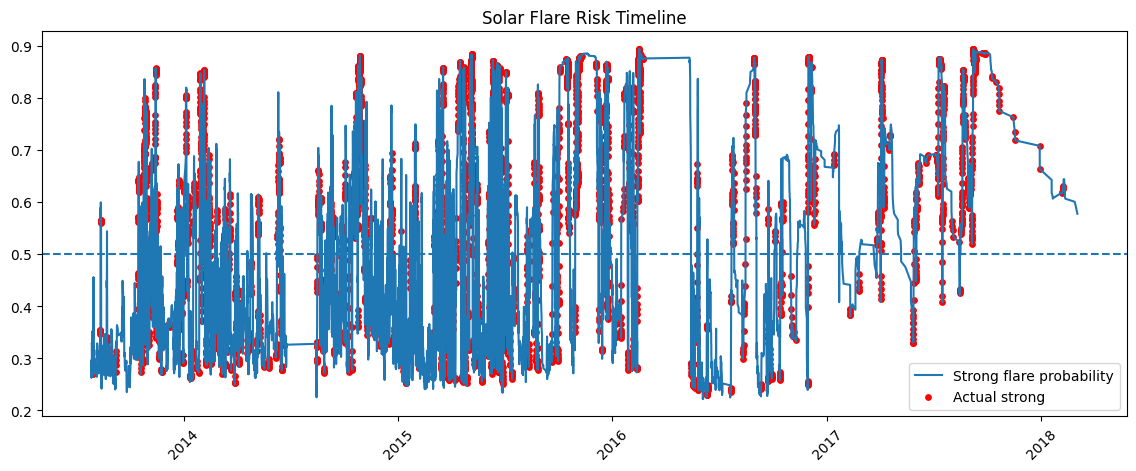

In [105]:
plt.figure(figsize=(14,5))

plt.plot(test_times, pred_prob, label="Strong flare probability")

strong_idx = y_test == 1
plt.scatter(test_times[strong_idx], pred_prob[strong_idx],
            color='red', s=15, label="Actual strong")

plt.axhline(0.5, linestyle='--')
plt.legend()
plt.xticks(rotation=45)
plt.title("Solar Flare Risk Timeline")
plt.show()


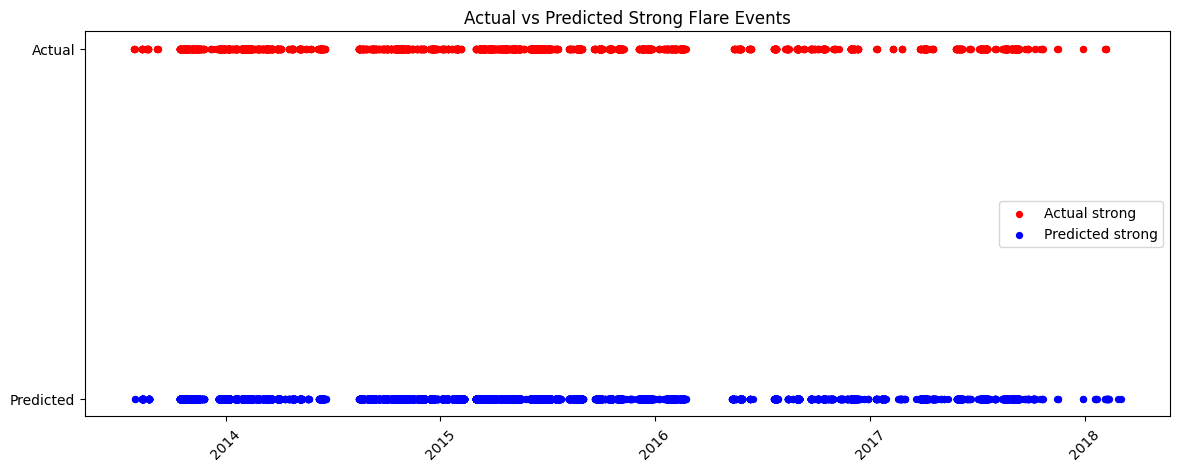

In [106]:
pred_class = (pred_prob > 0.45).astype(int)
plt.figure(figsize=(14,5))

actual_idx = y_test == 1
pred_idx = pred_class == 1

plt.scatter(test_times[actual_idx], np.ones(sum(actual_idx)),
            color='red', s=18, label="Actual strong")

plt.scatter(test_times[pred_idx], np.zeros(sum(pred_idx)),
            color='blue', s=18, label="Predicted strong")

plt.yticks([0,1], ["Predicted","Actual"])
plt.xticks(rotation=45)
plt.legend()
plt.title("Actual vs Predicted Strong Flare Events")
plt.show()



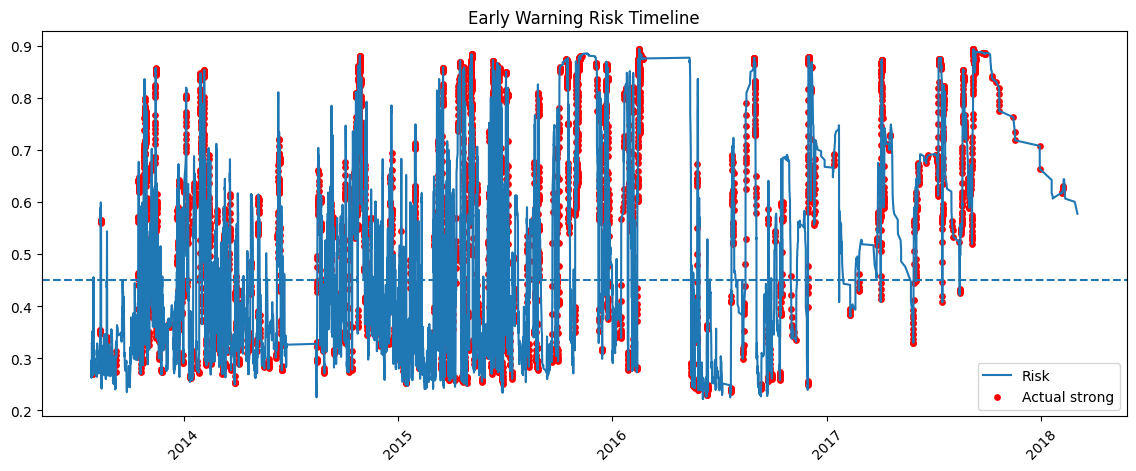

In [107]:
plt.figure(figsize=(14,5))

plt.plot(test_times, pred_prob, label="Risk")

strong_idx = y_test==1
plt.scatter(test_times[strong_idx], pred_prob[strong_idx],
            color='red', s=15, label="Actual strong")

plt.axhline(0.45, linestyle='--')
plt.legend()
plt.xticks(rotation=45)
plt.title("Early Warning Risk Timeline")
plt.show()


In [108]:
thresholds = np.linspace(0.2, 0.8, 50)

best_tss = -1
best_th = 0

for th in thresholds:
    pred = (pred_prob > th).astype(int)
    TN, FP, FN, TP = confusion_matrix(y_test, pred).ravel()

    recall = TP/(TP+FN) if (TP+FN)>0 else 0
    far = FP/(FP+TN) if (FP+TN)>0 else 0

    tss = recall - far

    if tss > best_tss:
        best_tss = tss
        best_th = th

print("Best threshold:", best_th)
print("Best TSS:", best_tss)

Best threshold: 0.5428571428571429
Best TSS: 0.2996998037913694


In [109]:
threshold = best_th
pred_class = (pred_prob > threshold).astype(int)

In [110]:
from sklearn.metrics import classification_report

print(classification_report(y_test, pred_class))

              precision    recall  f1-score   support

           0       0.92      0.65      0.76     35043
           1       0.24      0.65      0.35      5886

    accuracy                           0.65     40929
   macro avg       0.58      0.65      0.56     40929
weighted avg       0.82      0.65      0.70     40929



In [111]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, pred_class)
print(cm)

[[22874 12169]
 [ 2078  3808]]


In [112]:
from sklearn.metrics import roc_auc_score

roc = roc_auc_score(y_test, pred_prob)
print("ROC-AUC:", roc)

ROC-AUC: 0.6865272284429667


In [113]:
from sklearn.metrics import average_precision_score

pr = average_precision_score(y_test, pred_prob)
print("PR-AUC:", pr)

PR-AUC: 0.2942535666370376


In [114]:

TN, FP, FN, TP = cm.ravel()

recall = TP / (TP + FN)
false_alarm = FP / (FP + TN)

tss = recall - false_alarm

print("TSS:", tss)

TSS: 0.2996998037913694


In [115]:
model.save("solar_flare_model.h5")

In [116]:
import joblib
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']

In [117]:
from google.colab import files
files.download("scaler.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [118]:
model.save("solar_flare_model.h5")
files.download("solar_flare_model.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>